In [558]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [559]:
os.chdir(r"/Users/samueleckford/Python/Covid_19/covid_19_analysis/datasets/")

In [560]:
drop_columns = ['geoId', 'countryterritoryCode', 'day', 'month', 'year']

In [561]:
#target_country = "China"

In [562]:
# Import and format dataframe
covid19_df = pd.read_csv('COVID-19-geographic-disbtribution-worldwide-2020-05-05.csv', engine='python')

In [563]:
covid19_df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,05/05/2020,5,5,2020,190,5,Afghanistan,AF,AFG,37172386.0,Asia
1,04/05/2020,4,5,2020,235,13,Afghanistan,AF,AFG,37172386.0,Asia
2,03/05/2020,3,5,2020,134,4,Afghanistan,AF,AFG,37172386.0,Asia
3,02/05/2020,2,5,2020,164,4,Afghanistan,AF,AFG,37172386.0,Asia
4,01/05/2020,1,5,2020,222,4,Afghanistan,AF,AFG,37172386.0,Asia


In [564]:
covid19_df['dateRep'] = pd.to_datetime(covid19_df['dateRep'], dayfirst=True)
covid19_df.drop(columns=drop_columns, inplace=True)
covid19_df.head()

,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp
0,2020-05-05,190,5,Afghanistan,37172386.0,Asia
1,2020-05-04,235,13,Afghanistan,37172386.0,Asia
2,2020-05-03,134,4,Afghanistan,37172386.0,Asia
3,2020-05-02,164,4,Afghanistan,37172386.0,Asia
4,2020-05-01,222,4,Afghanistan,37172386.0,Asia


In [565]:
# Create df for one country
#country_df = covid19_df.loc[covid19_df.countriesAndTerritories == "China"].copy()

country_df = covid19_df.copy() 
country_df.sort_values(by=['dateRep'], ascending=True, inplace=True)
country_df.head()

,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp
14623,2019-12-31,0,0,United_States_of_America,327167434.0,America
12873,2019-12-31,0,0,South_Korea,51635256.0,Asia
1599,2019-12-31,0,0,Belgium,11422068.0,Europe
14446,2019-12-31,0,0,United_Kingdom,66488991.0,Europe
7357,2019-12-31,0,0,Italy,60431283.0,Europe


In [566]:
# Add cumulative columns for cases and deaths
# country_df['Cum Cases'] = country_df['cases'].cumsum()
# country_df['Cum Deaths'] = country_df['deaths'].cumsum()
country_df['Cum Cases'] = country_df.groupby("countriesAndTerritories")['cases'].cumsum()
country_df['Cum Deaths'] = country_df.groupby("countriesAndTerritories")['deaths'].cumsum()
country_df.head()

,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths
14623,2019-12-31,0,0,United_States_of_America,327167434.0,America,0,0
12873,2019-12-31,0,0,South_Korea,51635256.0,Asia,0,0
1599,2019-12-31,0,0,Belgium,11422068.0,Europe,0,0
14446,2019-12-31,0,0,United_Kingdom,66488991.0,Europe,0,0
7357,2019-12-31,0,0,Italy,60431283.0,Europe,0,0


In [567]:
# Create column for days since x deaths
country_df['flag'] = np.where(country_df['Cum Cases'] > 100, 1, 0) # this is fine to calculate globaly as its a true false, no agregaton at this stage

# Here I use the same logic as you. I filter the dataframe on cases (impartant to note i'm only filtering the grouped by dataframe). I then groupby the countriesAndTerritories
# column (again creating a unique dataframe for each country) and applying a cumulative sum to the "flag" column
country_df['flag'] = country_df.loc[country_df['Cum Cases'] > 100].groupby("countriesAndTerritories")['flag'].cumsum()

In [568]:
country_df['case_rate_inc'] = 1 + country_df.groupby("countriesAndTerritories")['cases'].pct_change()
country_df['death_rate_inc'] = 1 + country_df.groupby("countriesAndTerritories")['deaths'].pct_change()

In [569]:
country_df['5D_MA_cases'] = country_df.groupby("countriesAndTerritories")['case_rate_inc'].rolling(window=5).median().reset_index(0,drop=True)
country_df['5D_MA_deaths'] = country_df.groupby("countriesAndTerritories")['death_rate_inc'].rolling(window=5).median().reset_index(0,drop=True)
country_df.loc[country_df['Cum Cases'] > 2000].groupby("countriesAndTerritories").head()

,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths,flag,case_rate_inc,death_rate_inc,5D_MA_cases,5D_MA_deaths
3054,2020-01-27,787,25,China,1.392730e+09,Asia,2775,81,9.0,1.183459,1.666667,1.507937,NaN
3053,2020-01-28,1753,25,China,1.392730e+09,Asia,4528,106,10.0,2.227446,1.000000,1.702703,NaN
3052,2020-01-29,1466,26,China,1.392730e+09,Asia,5994,132,11.0,0.836281,1.040000,1.507937,1.040000
3051,2020-01-30,1740,38,China,1.392730e+09,Asia,7734,170,12.0,1.186903,1.461538,1.186903,1.040000
3050,2020-01-31,1980,43,China,1.392730e+09,Asia,9714,213,13.0,1.137931,1.131579,1.183459,1.131579
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5491,2020-05-05,550,0,Ghana,2.976711e+07,Africa,2719,18,40.0,inf,NaN,NaN,NaN
542,2020-05-05,121,4,Armenia,2.951776e+06,Europe,2507,39,48.0,1.070796,2.000000,NaN,NaN
10170,2020-05-05,244,6,Nigeria,1.958747e+08,Africa,2802,93,36.0,1.435294,3.000000,1.040816,1.428571
2457,2020-05-05,27,0,Cameroon,2.521624e+07,Africa,2104,64,36.0,inf,NaN,NaN,NaN


In [570]:
country_df['7D_MA_cases'] = country_df.groupby("countriesAndTerritories")['case_rate_inc'].rolling(window=7).median().reset_index(0,drop=True)
country_df['7D_MA_deaths'] = country_df.groupby("countriesAndTerritories")['death_rate_inc'].rolling(window=7).median().reset_index(0,drop=True)

In [571]:
top_count = country_df.groupby('countriesAndTerritories')['deaths'].sum().sort_values(ascending=False).iloc[:5]
#top_count = country_df['countriesAndTerritories'].value_counts().iloc[:20]
top_count

countriesAndTerritories
United_States_of_America    68934
Italy                       29079
United_Kingdom              28734
Spain                       25428
France                      25201
Name: deaths, dtype: int64

In [572]:
top_count = list(top_count.keys())

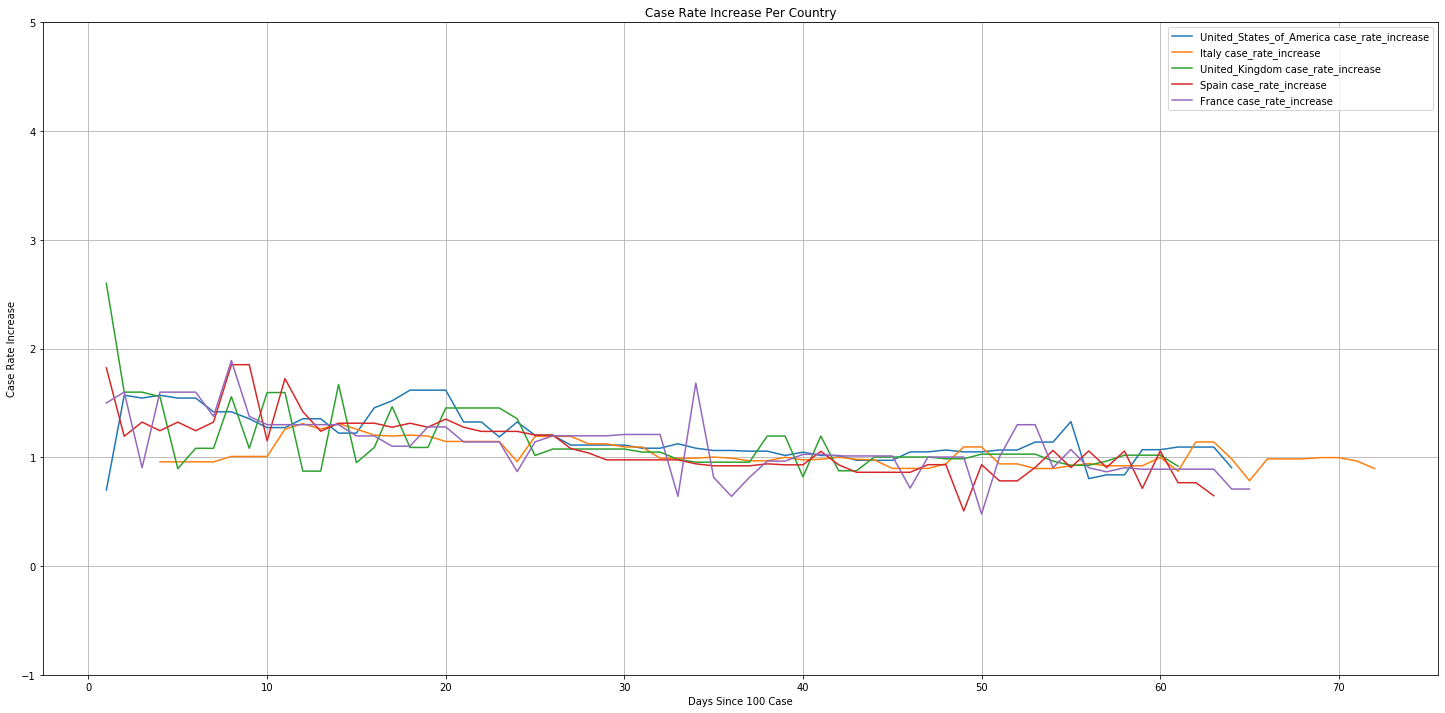

In [573]:
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
for country in top_count:
#    plt.scatter(coutry_df[country_df["countriesAndTerritories"] == country]["flag"],
#                df_model_train[df_model_train["tempCountry"] == country]["case_rate_increase"],
#                marker="o", label=f"{country} case rate increase")
#     plt.scatter(X_test[X_test["countryName"] == country]["flag"], X_test[X_test["countryName"] == country]["actualCases"], marker="x", label= f"{country} test actual cases")
    
    plt.plot(country_df[country_df["countriesAndTerritories"] == country]["flag"],
             country_df[country_df["countriesAndTerritories"] == country]["5D_MA_cases"], label=f"{country} case_rate_increase")
#     plt.plot(X_test[X_test["countryName"] == country]["flag"], X_test[X_test["countryName"] == country]["rf_prediction"])
plt.title('Case Rate Increase Per Country')
plt.xlabel('Days Since 100 Case')
#plt.legend()
plt.ylabel('Case Rate Increase')
plt.ylim(-1, 5)
#plt.xlim(0, 90)
plt.grid()
plt.legend()
plt.show()

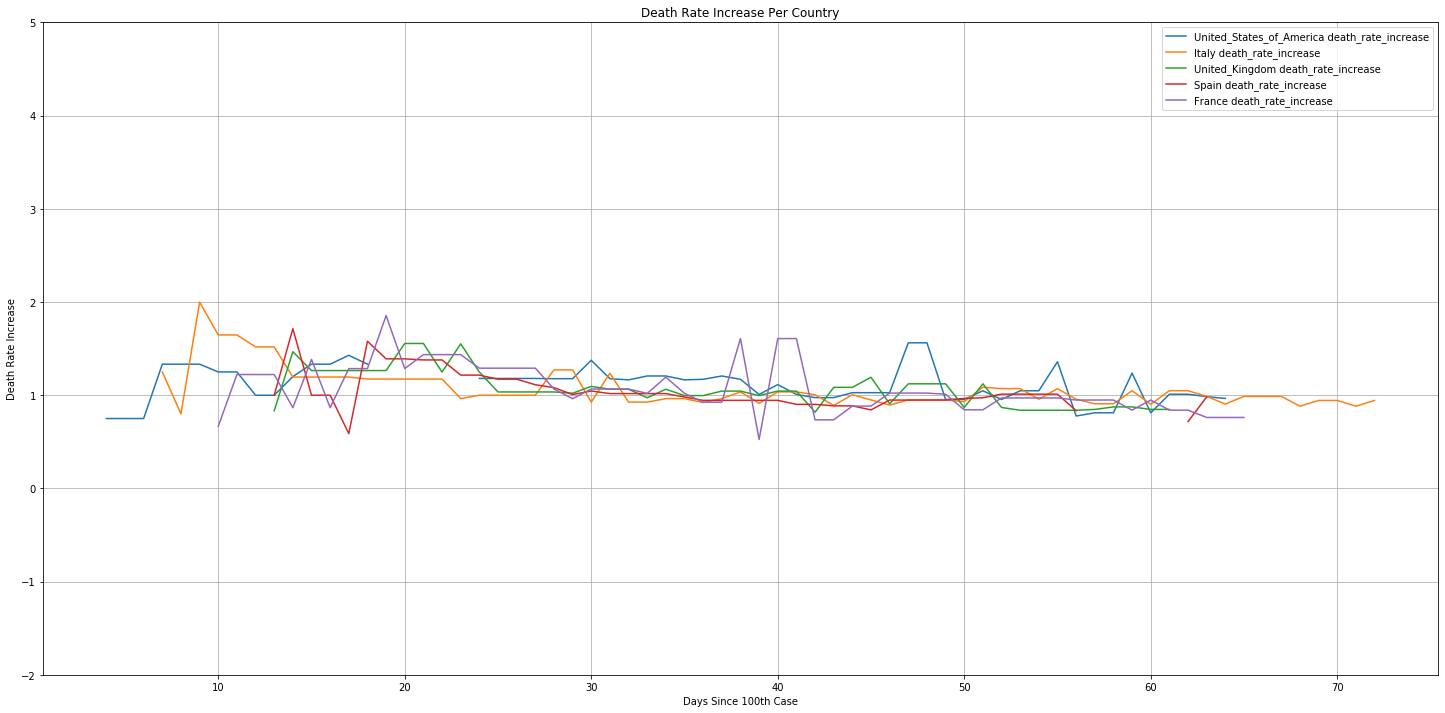

In [574]:
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
for country in top_count:
#    plt.scatter(coutry_df[country_df["countriesAndTerritories"] == country]["flag"],
#                df_model_train[df_model_train["tempCountry"] == country]["case_rate_increase"],
#                marker="o", label=f"{country} case rate increase")
#     plt.scatter(X_test[X_test["countryName"] == country]["flag"], X_test[X_test["countryName"] == country]["actualCases"], marker="x", label= f"{country} test actual cases")
    
    plt.plot(country_df[country_df["countriesAndTerritories"] == country]["flag"],
             country_df[country_df["countriesAndTerritories"] == country]["5D_MA_deaths"], label=f"{country} death_rate_increase")
#     plt.plot(X_test[X_test["countryName"] == country]["flag"], X_test[X_test["countryName"] == country]["rf_prediction"])
plt.title('Death Rate Increase Per Country')
plt.xlabel('Days Since 100th Case')
#plt.legend()
plt.ylabel('Death Rate Increase')
plt.ylim(-2, 5)
#plt.xlim(0, 90)
plt.grid()
plt.legend()
plt.show()

In [575]:
country_df.flag.fillna(0, inplace=True) # fill the nans in the flag column as a reult of mergining in the filtered groupby
country_df.case_rate_inc.fillna(0, inplace=True) # fill the nans in the case rate column as a reult of mergining in the filtered groupby

In [576]:
country_df_mean = country_df[country_df['countriesAndTerritories'].isin(top_count)].groupby('flag').mean()
country_df_mean.head()

,cases,deaths,popData2018,Cum Cases,Cum Deaths,case_rate_inc,death_rate_inc,5D_MA_cases,5D_MA_deaths,7D_MA_cases,7D_MA_deaths
flag,,,,,,,,,,,
0.0,1.411003,0.019417,1.146290e+08,7.294498,0.080906,inf,inf,2.237500,NaN,NaN,NaN
1.0,31.600000,0.800000,1.135597e+08,118.800000,2.000000,0.991679,2.00,1.655882,NaN,2.161765,NaN
2.0,50.400000,1.800000,1.135597e+08,169.200000,3.800000,1.559033,inf,1.491244,NaN,1.875000,NaN
3.0,50.600000,2.000000,1.135597e+08,219.800000,5.800000,1.086542,inf,1.343635,NaN,1.492445,NaN
4.0,70.600000,0.800000,1.135597e+08,290.400000,6.600000,1.593055,0.54,1.386646,0.75,1.493617,NaN


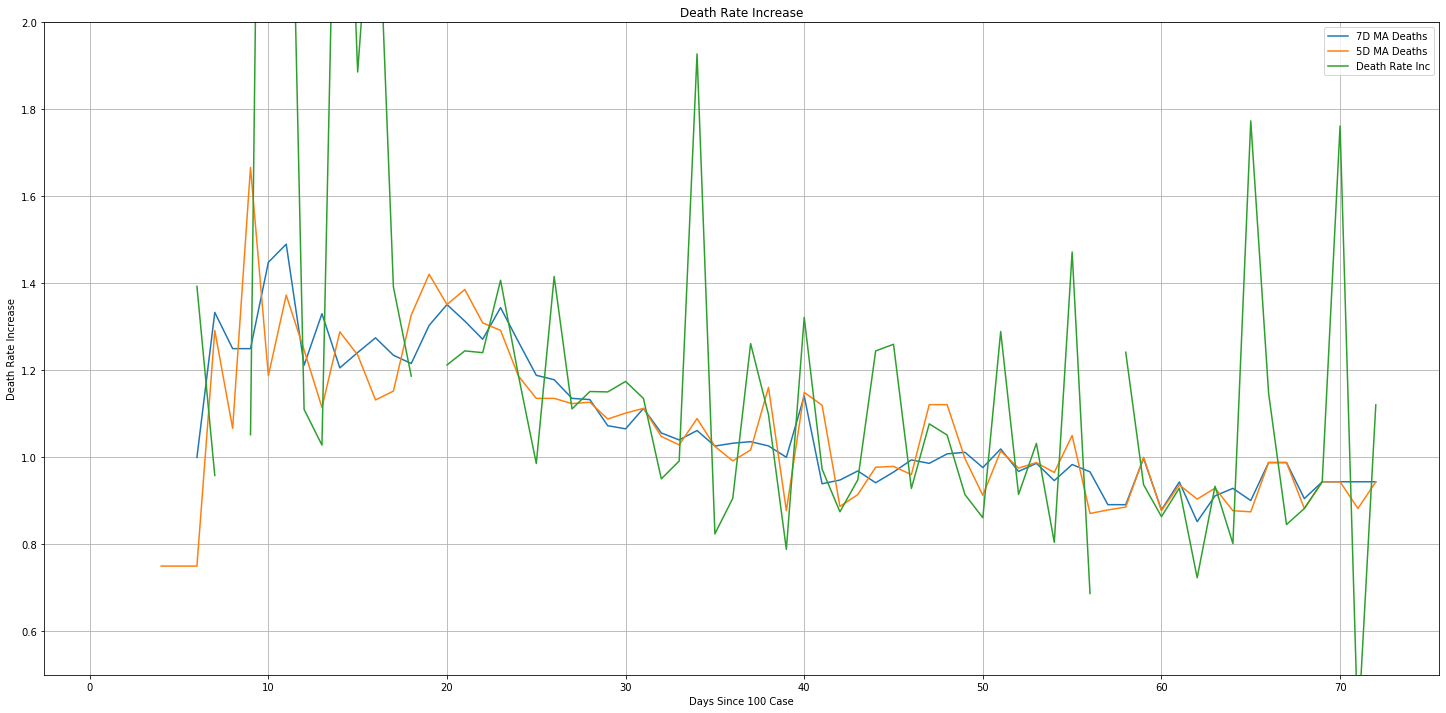

In [577]:
plt.figure(figsize=(25, 12))
plt.plot(country_df_mean.index, country_df_mean['7D_MA_deaths'], label='7D MA Deaths')
plt.plot(country_df_mean.index, country_df_mean['5D_MA_deaths'], label='5D MA Deaths')
plt.plot(country_df_mean.index, country_df_mean['death_rate_inc'], label='Death Rate Inc')
plt.title('Death Rate Increase')
plt.xlabel('Days Since 100 Case')
#plt.legend()
plt.ylabel('Death Rate Increase')
plt.ylim(0.5, 2)
#plt.xlim(0, 90)
plt.grid()
plt.legend()
plt.show()

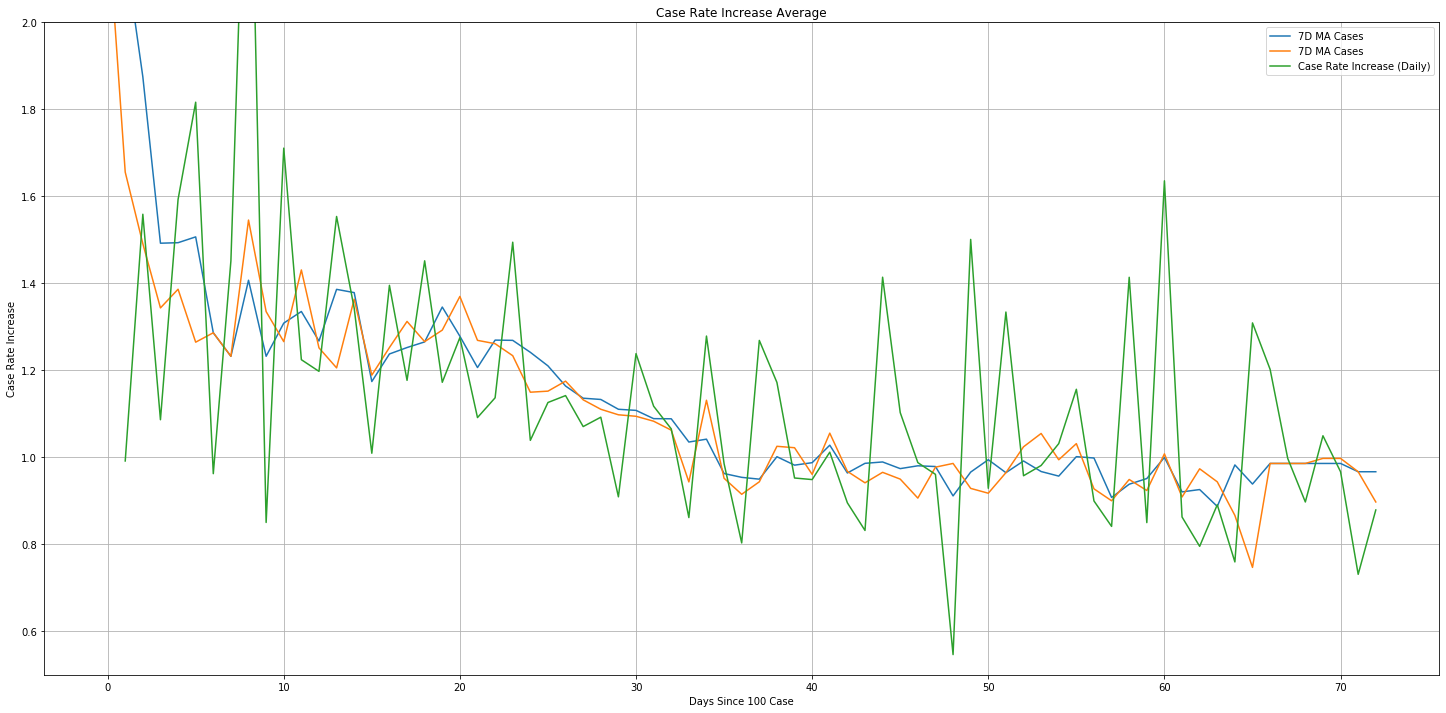

In [578]:
plt.figure(figsize=(25, 12))
plt.plot(country_df_mean.index, country_df_mean['7D_MA_cases'], label='7D MA Cases')
plt.plot(country_df_mean.index, country_df_mean['5D_MA_cases'], label='7D MA Cases')
plt.plot(country_df_mean.index, country_df_mean['case_rate_inc'], label='Case Rate Increase (Daily)')
plt.title('Case Rate Increase Average')
plt.xlabel('Days Since 100 Case')
#plt.legend()
plt.ylabel('Case Rate Increase')
plt.ylim(0.5, 2)
#plt.xlim(0, 90)
plt.grid()
plt.legend()
plt.show()

In [579]:
country_df_mean.drop(['cases', 'deaths', 'Cum Cases', 'Cum Deaths', 'popData2018'], axis=1, inplace=True)

In [580]:
country_df_mean = country_df_mean.loc[(country_df_mean.index > 0)]
country_df_mean.rename(columns={"case_rate_inc": "case_rate_inc_global", "death_rate_inc": "death_rate_inc_global",\
                                '5D_MA_cases':'5D_MA_cases_global', '5D_MA_deaths': '5D_MA_deaths_global', '7D_MA_cases': '7D_MA_cases_global', '7D_MA_deaths':'7D_MA_deaths_global'}, inplace=True)
country_df_mean.head()

,case_rate_inc_global,death_rate_inc_global,5D_MA_cases_global,5D_MA_deaths_global,7D_MA_cases_global,7D_MA_deaths_global
flag,,,,,,
1.0,0.991679,2.00,1.655882,NaN,2.161765,NaN
2.0,1.559033,inf,1.491244,NaN,1.875000,NaN
3.0,1.086542,inf,1.343635,NaN,1.492445,NaN
4.0,1.593055,0.54,1.386646,0.75,1.493617,NaN
5.0,1.816667,inf,1.264875,0.75,1.506980,NaN


In [599]:
country_df_2 = country_df.drop(['5D_MA_cases', '5D_MA_deaths', '7D_MA_cases', '7D_MA_deaths', 'case_rate_inc', 'death_rate_inc'], axis=1)
#country_df_2.join(country_df_mean, on=[country_df_mean.index,country_df.flag], how='outer')
#country_df_2.loc[(country_df_2['countriesAndTerritories'] == 'United_Kingdom')].tail()
country_df_2['5D_MA_cases'] = country_df.groupby("countriesAndTerritories")['cases'].rolling(window=5).mean().reset_index(0,drop=True)
country_df_2['5D_MA_deaths'] = country_df.groupby("countriesAndTerritories")['deaths'].rolling(window=5).mean().reset_index(0,drop=True)
country_df_2[country_df_2.countriesAndTerritories =="United_Kingdom"].iloc[50:52]

,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths,flag,5D_MA_cases,5D_MA_deaths
14396,2020-02-19,0,0,United_Kingdom,66488991.0,Europe,9,0,0.0,0.0,0.0
14395,2020-02-20,0,0,United_Kingdom,66488991.0,Europe,9,0,0.0,0.0,0.0


In [600]:
for country in top_count:
    country_len = len(country_df_2.loc[(country_df_2['countriesAndTerritories'] == country) & (country_df_2['flag'] > 0)])
    blank_df = pd.DataFrame(columns=['flag', 'countriesAndTerritories', 'dateRep', 'popData2018', 'cum_7D_MA_deaths_global', '7D_DeathPred'], index=np.arange(len(country_df_mean) - country_len))
    for i in range(len(country_df_mean) - country_len):
        date_value_max = pd.DateOffset(i + 1) + country_df_2.loc[(country_df_2['countriesAndTerritories'] == country)]['dateRep'].max()
        pop_value = country_df_2.loc[(country_df_2['dateRep'] == (country_df_2.loc[(country_df_2['countriesAndTerritories'] == country)]['dateRep'].max())) & (country_df_2['countriesAndTerritories'] == country)]['popData2018'].iloc[0]
        continentExp_value = country_df_2.loc[(country_df_2['dateRep'] == (country_df_2.loc[(country_df_2['countriesAndTerritories'] == country)]['dateRep'].max())) & (country_df_2['countriesAndTerritories'] == country)]['continentExp'].iloc[0]
        deathpred_value = country_df_2.loc[(country_df_2['dateRep'] == (country_df_2.loc[(country_df_2['countriesAndTerritories'] == country)]['dateRep'].max())) & (country_df_2['countriesAndTerritories'] == country)]['5D_MA_deaths'].iloc[0]
        cumprod_value = 1
        blank_df = blank_df.append({'flag': (i + country_len + 1), 'countriesAndTerritories': country, 'dateRep': date_value_max, 'popData2018': pop_value, 'continentExp': continentExp_value, 'cum_7D_MA_deaths_global': 1, '7D_DeathPred': deathpred_value}, ignore_index=True)
    country_df_2 = pd.concat([country_df_2, blank_df])
country_df_2.loc[country_df_2['countriesAndTerritories'] == 'United_Kingdom'].tail()

,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths,flag,5D_MA_cases,5D_MA_deaths,cum_7D_MA_deaths_global,7D_DeathPred
17,2020-05-12,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,68,NaN,NaN,1,527.4
18,2020-05-13,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,69,NaN,NaN,1,527.4
19,2020-05-14,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,70,NaN,NaN,1,527.4
20,2020-05-15,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,71,NaN,NaN,1,527.4
21,2020-05-16,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,72,NaN,NaN,1,527.4


In [601]:
country_df_2 = country_df_2.merge(country_df_mean, left_on=country_df_2.flag, right_on=country_df_mean.index)
country_df_2[country_df_2.countriesAndTerritories =="United_Kingdom"].iloc[59:64]

,key_0,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths,flag,5D_MA_cases,5D_MA_deaths,cum_7D_MA_deaths_global,7D_DeathPred,case_rate_inc_global,death_rate_inc_global,5D_MA_cases_global,5D_MA_deaths_global,7D_MA_cases_global,7D_MA_deaths_global
6116,60.0,2020-05-04,4339.0,315.0,United_Kingdom,66488991.0,Europe,186599.0,28446.0,60,5090.8,628.8,NaN,NaN,1.635935,0.863781,1.008047,0.877492,0.999852,0.879033
6132,61.0,2020-05-05,3985.0,288.0,United_Kingdom,66488991.0,Europe,190584.0,28734.0,61,5072.6,527.4,NaN,NaN,0.862862,0.929175,0.908849,0.936725,0.920597,0.943422
6143,62.0,2020-05-06,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,62,NaN,NaN,1,527.4,0.795428,0.723100,0.973685,0.903968,0.925972,0.852163
6154,63.0,2020-05-07,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,63,NaN,NaN,1,527.4,0.890982,0.933594,0.943725,0.929146,0.887244,0.911459
6164,64.0,2020-05-08,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,64,NaN,NaN,1,527.4,0.759547,0.801688,0.866502,0.877315,0.982598,0.928721


In [602]:
country_df_2['cum_7D_MA_deaths_global'] = country_df_2['cum_7D_MA_deaths_global'] * country_df_2['7D_MA_deaths_global']
country_df_2[country_df_2.countriesAndTerritories =="United_Kingdom"].iloc[59:64]

,key_0,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths,flag,5D_MA_cases,5D_MA_deaths,cum_7D_MA_deaths_global,7D_DeathPred,case_rate_inc_global,death_rate_inc_global,5D_MA_cases_global,5D_MA_deaths_global,7D_MA_cases_global,7D_MA_deaths_global
6116,60.0,2020-05-04,4339.0,315.0,United_Kingdom,66488991.0,Europe,186599.0,28446.0,60,5090.8,628.8,NaN,NaN,1.635935,0.863781,1.008047,0.877492,0.999852,0.879033
6132,61.0,2020-05-05,3985.0,288.0,United_Kingdom,66488991.0,Europe,190584.0,28734.0,61,5072.6,527.4,NaN,NaN,0.862862,0.929175,0.908849,0.936725,0.920597,0.943422
6143,62.0,2020-05-06,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,62,NaN,NaN,0.852163,527.4,0.795428,0.723100,0.973685,0.903968,0.925972,0.852163
6154,63.0,2020-05-07,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,63,NaN,NaN,0.911459,527.4,0.890982,0.933594,0.943725,0.929146,0.887244,0.911459
6164,64.0,2020-05-08,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,64,NaN,NaN,0.928721,527.4,0.759547,0.801688,0.866502,0.877315,0.982598,0.928721


In [603]:
country_df_2['cum_7D_MA_deaths_global'] = country_df_2['cum_7D_MA_deaths_global'].astype(float)

In [604]:
country_df_2['cum_7D_MA_deaths_global'] = country_df_2.groupby('countriesAndTerritories')['cum_7D_MA_deaths_global'].cumprod()

In [605]:
country_df_2['7D_DeathPred'] = country_df_2['7D_DeathPred'] * country_df_2['cum_7D_MA_deaths_global']
country_df_2[country_df_2.countriesAndTerritories =="United_Kingdom"].iloc[59:64]

,key_0,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths,flag,5D_MA_cases,5D_MA_deaths,cum_7D_MA_deaths_global,7D_DeathPred,case_rate_inc_global,death_rate_inc_global,5D_MA_cases_global,5D_MA_deaths_global,7D_MA_cases_global,7D_MA_deaths_global
6116,60.0,2020-05-04,4339.0,315.0,United_Kingdom,66488991.0,Europe,186599.0,28446.0,60,5090.8,628.8,NaN,NaN,1.635935,0.863781,1.008047,0.877492,0.999852,0.879033
6132,61.0,2020-05-05,3985.0,288.0,United_Kingdom,66488991.0,Europe,190584.0,28734.0,61,5072.6,527.4,NaN,NaN,0.862862,0.929175,0.908849,0.936725,0.920597,0.943422
6143,62.0,2020-05-06,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,62,NaN,NaN,0.852163,449.430775,0.795428,0.723100,0.973685,0.903968,0.925972,0.852163
6154,63.0,2020-05-07,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,63,NaN,NaN,0.776712,409.637740,0.890982,0.933594,0.943725,0.929146,0.887244,0.911459
6164,64.0,2020-05-08,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,64,NaN,NaN,0.721348,380.439065,0.759547,0.801688,0.866502,0.877315,0.982598,0.928721
6175,65.0,2020-05-09,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,65,NaN,NaN,0.649700,342.651622,1.309204,1.773718,0.746969,0.874782,0.938606,0.900674
6185,66.0,2020-05-10,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,66,NaN,NaN,0.641965,338.572436,1.202415,1.147147,0.985999,0.988095,0.985999,0.988095
6194,67.0,2020-05-11,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,67,NaN,NaN,0.634323,334.541812,0.997609,0.845550,0.985999,0.988095,0.985999,0.988095
6203,68.0,2020-05-12,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,68,NaN,NaN,0.574171,302.818019,0.897411,0.882353,0.985999,0.882353,0.985999,0.905172
6212,69.0,2020-05-13,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,69,NaN,NaN,0.541937,285.817709,1.049679,0.943860,0.997609,0.943860,0.985999,0.943860


In [606]:
country_df_2['7D_Full_Death'] = country_df_2['7D_DeathPred']
country_df_2['7D_Full_Death'].fillna(country_df_2.deaths, inplace=True)
country_df_2[country_df_2.countriesAndTerritories =="United_Kingdom"].iloc[59:64]

,key_0,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths,flag,...,5D_MA_deaths,cum_7D_MA_deaths_global,7D_DeathPred,case_rate_inc_global,death_rate_inc_global,5D_MA_cases_global,5D_MA_deaths_global,7D_MA_cases_global,7D_MA_deaths_global,7D_Full_Death
6116,60.0,2020-05-04,4339.0,315.0,United_Kingdom,66488991.0,Europe,186599.0,28446.0,60,...,628.8,NaN,NaN,1.635935,0.863781,1.008047,0.877492,0.999852,0.879033,315.000000
6132,61.0,2020-05-05,3985.0,288.0,United_Kingdom,66488991.0,Europe,190584.0,28734.0,61,...,527.4,NaN,NaN,0.862862,0.929175,0.908849,0.936725,0.920597,0.943422,288.000000
6143,62.0,2020-05-06,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,62,...,NaN,0.852163,449.430775,0.795428,0.723100,0.973685,0.903968,0.925972,0.852163,449.430775
6154,63.0,2020-05-07,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,63,...,NaN,0.776712,409.637740,0.890982,0.933594,0.943725,0.929146,0.887244,0.911459,409.637740
6164,64.0,2020-05-08,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,64,...,NaN,0.721348,380.439065,0.759547,0.801688,0.866502,0.877315,0.982598,0.928721,380.439065
6175,65.0,2020-05-09,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,65,...,NaN,0.649700,342.651622,1.309204,1.773718,0.746969,0.874782,0.938606,0.900674,342.651622
6185,66.0,2020-05-10,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,66,...,NaN,0.641965,338.572436,1.202415,1.147147,0.985999,0.988095,0.985999,0.988095,338.572436
6194,67.0,2020-05-11,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,67,...,NaN,0.634323,334.541812,0.997609,0.845550,0.985999,0.988095,0.985999,0.988095,334.541812
6203,68.0,2020-05-12,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,68,...,NaN,0.574171,302.818019,0.897411,0.882353,0.985999,0.882353,0.985999,0.905172,302.818019
6212,69.0,2020-05-13,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,69,...,NaN,0.541937,285.817709,1.049679,0.943860,0.997609,0.943860,0.985999,0.943860,285.817709


In [607]:
country_df_2['7D_Full_Death_cum'] = country_df_2.groupby('countriesAndTerritories')['7D_Full_Death'].cumsum()

,key_0,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths,flag,...,cum_7D_MA_deaths_global,7D_DeathPred,case_rate_inc_global,death_rate_inc_global,5D_MA_cases_global,5D_MA_deaths_global,7D_MA_cases_global,7D_MA_deaths_global,7D_Full_Death,7D_Full_Death_cum
6116,60.0,2020-05-04,4339.0,315.0,United_Kingdom,66488991.0,Europe,186599.0,28446.0,60,...,NaN,NaN,1.635935,0.863781,1.008047,0.877492,0.999852,0.879033,315.000000,28446.000000
6132,61.0,2020-05-05,3985.0,288.0,United_Kingdom,66488991.0,Europe,190584.0,28734.0,61,...,NaN,NaN,0.862862,0.929175,0.908849,0.936725,0.920597,0.943422,288.000000,28734.000000
6143,62.0,2020-05-06,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,62,...,0.852163,449.430775,0.795428,0.723100,0.973685,0.903968,0.925972,0.852163,449.430775,29183.430775
6154,63.0,2020-05-07,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,63,...,0.776712,409.637740,0.890982,0.933594,0.943725,0.929146,0.887244,0.911459,409.637740,29593.068515
6164,64.0,2020-05-08,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,64,...,0.721348,380.439065,0.759547,0.801688,0.866502,0.877315,0.982598,0.928721,380.439065,29973.507580


In [608]:
country_df_2[country_df_2.countriesAndTerritories =="United_Kingdom"].iloc[59:90]

,key_0,dateRep,cases,deaths,countriesAndTerritories,popData2018,continentExp,Cum Cases,Cum Deaths,flag,...,cum_7D_MA_deaths_global,7D_DeathPred,case_rate_inc_global,death_rate_inc_global,5D_MA_cases_global,5D_MA_deaths_global,7D_MA_cases_global,7D_MA_deaths_global,7D_Full_Death,7D_Full_Death_cum
6116,60.0,2020-05-04,4339.0,315.0,United_Kingdom,66488991.0,Europe,186599.0,28446.0,60,...,NaN,NaN,1.635935,0.863781,1.008047,0.877492,0.999852,0.879033,315.000000,28446.000000
6132,61.0,2020-05-05,3985.0,288.0,United_Kingdom,66488991.0,Europe,190584.0,28734.0,61,...,NaN,NaN,0.862862,0.929175,0.908849,0.936725,0.920597,0.943422,288.000000,28734.000000
6143,62.0,2020-05-06,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,62,...,0.852163,449.430775,0.795428,0.723100,0.973685,0.903968,0.925972,0.852163,449.430775,29183.430775
6154,63.0,2020-05-07,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,63,...,0.776712,409.637740,0.890982,0.933594,0.943725,0.929146,0.887244,0.911459,409.637740,29593.068515
6164,64.0,2020-05-08,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,64,...,0.721348,380.439065,0.759547,0.801688,0.866502,0.877315,0.982598,0.928721,380.439065,29973.507580
6175,65.0,2020-05-09,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,65,...,0.649700,342.651622,1.309204,1.773718,0.746969,0.874782,0.938606,0.900674,342.651622,30316.159202
6185,66.0,2020-05-10,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,66,...,0.641965,338.572436,1.202415,1.147147,0.985999,0.988095,0.985999,0.988095,338.572436,30654.731638
6194,67.0,2020-05-11,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,67,...,0.634323,334.541812,0.997609,0.845550,0.985999,0.988095,0.985999,0.988095,334.541812,30989.273450
6203,68.0,2020-05-12,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,68,...,0.574171,302.818019,0.897411,0.882353,0.985999,0.882353,0.985999,0.905172,302.818019,31292.091469
6212,69.0,2020-05-13,NaN,NaN,United_Kingdom,66488991.0,Europe,NaN,NaN,69,...,0.541937,285.817709,1.049679,0.943860,0.997609,0.943860,0.985999,0.943860,285.817709,31577.909178
